# beams tutorial

## Setup

Clone the repository to your desired location using `git clone https://github.com/rushinc/beams`.
Append the `beams` parent directory to your `PYTHONPATH`. Easiest is to use the `sys` module.
Update the path in the cell below and that's it!

In [1]:
import sys
sys.path.append('/home/rushin/Documents/Python/') # Modify this line

import beams as bm
import numpy as np
import matplotlib.pyplot as plt

## Inputs

First, we define all the input parameters which define the geometry of our structure as well as the frequency and momentum to solve at.

We begin with the wavelength or frequency. In units where the speed of light $c=1$ the frequency and wavelength are simply the inverse of each other.

The unit for wavelength is chosen to be μm but is not important as long as all other geometric parameters are defined in the same units.

In [2]:
y = 1.55
freq = 1 / y

The angle of incident light is determined by the momentum along the $x$- and $y$-directions. For normal incidence $k_x = k_y = 0$.

In [3]:
kx = 0
ky = 0
k = bm.Vector2d(kx, ky)

The accuracy and the computational size of the problem is determined by the number of modes solved for. The size of matrices will be proportional to $N = N_x N_y$.

The time complexity of the linear algebra routines is $\mathcal{O}(N^3)$. So the serial version should scale accordingly.

In [4]:
N_x = 13
N_y = 13
N = N_x * N_y
N_modes = bm.Vector2d(N_x, N_y)

## Materials

The physical response of the materials can be defined and accessed using `beams.materials.Material`. For now, we will only use this interface to assign a frequency-independent complex permittivity or refractive index. Later, this functionality will be extended to magnetic materials as well as frequency-dependent dispersion.

The materials we use for this example are air, silicon and glass.

In [5]:
air = bm.Material()
SiO2 = bm.Material(epsilon=1.5 ** 2)
Si = bm.Material(epsilon=3.4 ** 2)

## Geometry

The sensor we will analyze here is from [this paper](https://www.degruyter.com/view/journals/nanoph/ahead-of-print/article-10.1515-nanoph-2020-0008/article-10.1515-nanoph-2020-0008.xml). The unit cell (from Fig. 2) is reproduced below.

![Unit cell](cell.png)

The values of the parameters shown above are defined as follows:

In [6]:
px = .810
py = px
p = bm.Vector2d(px, py)
h = .320 # = h_c
L = .600 
w_1 = .230
w_2 = .190
g = .125
C_1 = bm.Vector2d(y=-(w_1 + g)/2)       # Center of Si bar 1
C_2 = bm.Vector2d(y=(w_2 + g)/2)        # Center of Si bar 1

Now we can construct the rectangles using the `beams.shapes` module. The `Shape` class takes three arguments to construct; these determine the material of the shape, the center, and a function which returns a `boolean` for every `Vector2d` input indicating whether the point lies inside or outside the shape.

Currently, this module only defines rectangles and ellipses but adding more shapes is pretty trivial.

In [7]:
bar1 = bm.Rectangle(size=bm.Vector2d(L, w_1), center=C_1, material=Si)
bar2 = bm.Rectangle(size=bm.Vector2d(L, w_2), center=C_2, material=Si)

## Layers
The most important class in `beams` is the `Layer` class. `Layer` objects solve the eigenvalue problem of Maxwell's equations in 2D.

To define a layer we pass in a list of shapes that belong to the layer, a default material which is present at all points which do not lie in the interior of the passed shapes, and an integer resolution. 

The resolution is number of pixels our length scale is divided in. So a resolution of $1000$ as passed below means that one pixel on our grid is equal to $1$ nm. This resolution is what determines the size of the FFT problem which should scale as $\mathcal{O}(R \log R)$.

In [8]:
res = 1000
shapes = [bar1, bar2]
bars = bm.Layer(h, shapes, air, res)

Now that a layer has been initialized we can run some preliminary tests on how the layer looks like. First, let us see if the shapes have been correctly defined. The `Layer.grid(period, value='id')` method will return of grid of the specified value which we can quickly plot using `matplotlib`.

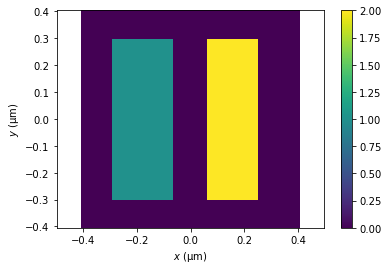

In [9]:
(axs, sgrid) = bars.grid(period=p)
plt.pcolormesh(axs.x, axs.y, sgrid)
plt.xlim([-px / 2, px / 2])
plt.xlabel('$x$ (μm)')
plt.ylim([-py / 2, py / 2])
plt.ylabel('$y$ (μm)')
plt.axis('equal')
plt.colorbar()
plt.show()

This does look like a 2D projection of the two silicon bars from the unit cell. The different colors of the two rectangles indicate that these are distinct shapes having a unique id. Mostly though, we just want see the permittivity distribution. To do that we can pass `value='eps'` to `Layer.grid`.

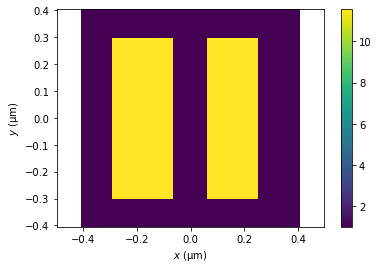

In [10]:
(_, epsgrid) = bars.grid(period=p, feature='eps')
plt.pcolormesh(axs.x, axs.y, epsgrid)
plt.xlim([-px / 2, px / 2])
plt.xlabel('$x$ (μm)')
plt.ylim([-py / 2, py / 2])
plt.ylabel('$y$ (μm)')
plt.axis('equal')
plt.colorbar()
plt.show()

This shows that the two bars have the same permittivty $\epsilon \approx 12$.



Now that everything looks good we can run the most intensive computation on this layer. Everything needed to solve a layer is contained in the `Layer.compute_eigs` method. This method internally calls `Layer.__ffts` and `Layer.__eigs` methods.

The `ffts` method only depends on the resolution of the layer $R$ and changing $N$ will have minimal impact on the computation of FFTs. Only the number of FFT terms retained is defined by $N$. On the other hand, the `mode_solve` method does not depend on the resolution of a layer. Thus, `compute_eigs` should scale independently for both variables $N$ and $R$.

This method will store the eigenvalues and eigenmatrices in the `Layer` object. Later, these matrices will be used to solve the large linear system. 

In [11]:
bars.compute_eigs(freq, k, p, N_modes)

These matrices have also been stored in `bars` and they can be used to visualize a particular eigenmode of the this layer. To do that we need to pass the points we want the fields to be computed to the `Layer.field` method.

Moreover, the method also requires a $N$-size `Vector2d` array which contains the amplitude of the modes. This array `C` will be the solution of the linear system but to glimpse a single mode, `C` can be set to have a single non-zero value which will correspond to the mode index that will be computed.

This method can also be demanding based on the resolution of the grid and is one of the methods we should focus on.

The weird patterns seen on changing `n` are the forms light would take when it travels through an infinite `bars`-like layer.

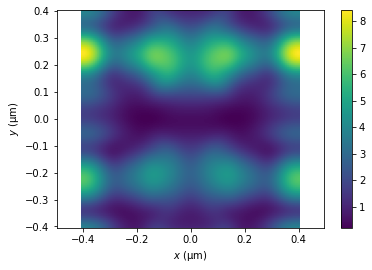

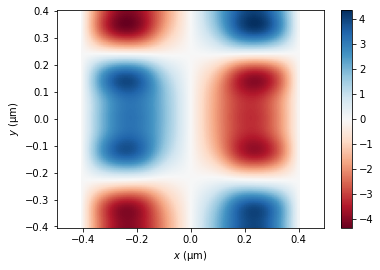

In [12]:
r = 400
grid = np.ogrid[-p.x / 2:p.x / 2:1 / r, -p.y / 2:p.y / 2:1 / r]
vgrid = bm.Vector3d(grid[0], grid[1].T)
n = 42
c = np.vstack((np.zeros((n, 1)), 1, np.zeros((2 * N - n - 1, 1))))
C = bm.Vector2d(c[:N], c[N:])
(E, H) = bars.get_fields(vgrid, C)

plt.pcolormesh(vgrid.x.T, vgrid.y, E[:,:,0].intensity().T)
plt.xlim([-px / 2, px / 2])
plt.xlabel('$x$ (μm)')
plt.ylim([-py / 2, py / 2])
plt.ylabel('$y$ (μm)')
plt.axis('equal')
plt.colorbar()
plt.show()

plt.pcolormesh(vgrid.x.T, vgrid.y, np.real(H.z[:,:,0]).T, cmap='RdBu')
plt.xlim([-px / 2, px / 2])
plt.xlabel('$x$ (μm)')
plt.ylim([-py / 2, py / 2])
plt.ylabel('$y$ (μm)')
plt.axis('equal')
plt.colorbar()
plt.show()

## Cell

The simulation domain is in reality a 3D periodic unit cell and not simply a 2D layer. To solve Maxwell's equations consistently across multiple layers we utilize the `Cell` class. Here, we will store all the layers to be included in the geometry and define the numerical methods which sequentially compute the eigenmodes of each layer and solve the linear system.

Let's define two more layers: one acts as the incidence layer and the other as the transmission layer. If a layer is initialized with a height of $0$ it will be assumed to be infinite unless in the direction that has another layer adjacent to it.

In [13]:
inc = bm.Layer()
sub = bm.Layer(material=SiO2)
layers = [inc, bars, sub]

cell = bm.Cell(p, N_modes, layers)

The `Cell.fields` method can now compute the field distribution at any point in the cell. We call the method with the desired frequency and a `Vector3d` object which are the three angular degrees of freedom of the electric field polarization.

To look at the cross-section of the fields along the center of the layer we set the $z$-component of our grid first.

In [14]:
angles = bm.Vector3d()
vgrid.z = bars.h / 2
(E, H) = cell.fields(freq, angles, vgrid)

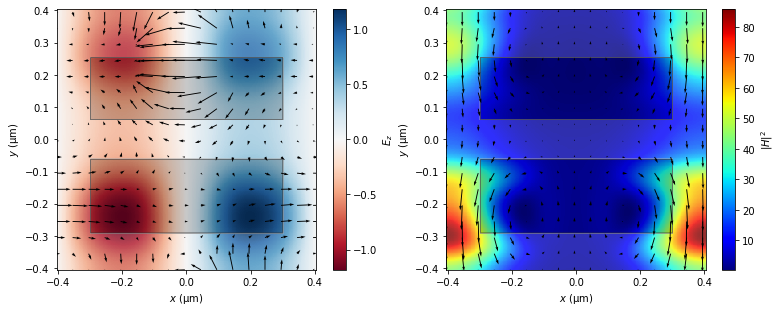

In [15]:
(axs, epsgrid) = bars.grid(period=p, feature='eps', resolution=r)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[12.8, 4.8])

im1 = ax1.pcolormesh(vgrid.x.T, vgrid.y, np.real(E[:,:,0].z).T, cmap='RdBu')
fig.colorbar(im1, ax=ax1, label='$E_z$')
ax1.contourf(axs.x, axs.y, epsgrid.T, cmap='gray_r', alpha=0.20)
ax1.quiver(vgrid.x[::20].T, vgrid.y[::20], np.real(E[::20,::20,0].x).T, np.real(E[::20,::20,0].y).T)
ax1.set_xlim([-px / 2, px / 2])
ax1.set_xlabel('$x$ (μm)')
ax1.set_ylim([-py / 2, py / 2])
ax1.set_ylabel('$y$ (μm)')

im2 = ax2.pcolormesh(vgrid.x.T, vgrid.y, H[:, :, 0].intensity().T, cmap='jet')
fig.colorbar(im2, ax=ax2, label='$|H|^2$')
ax2.contourf(axs.x, axs.y, epsgrid.T, cmap='gray_r', alpha=0.20)
ax2.quiver(vgrid.x[::20].T, vgrid.y[::20], np.real(H[::20,::20,0].x).T, np.real(H[::20,::20,0].y).T)
ax2.set_xlim([-px / 2, px / 2])
ax2.set_xlabel('$x$ (μm)')
ax2.set_ylim([-py / 2, py / 2])
ax2.set_ylabel('$y$ (μm)')
plt.show()

The `Cell` object will also store the solutions to the linear system and obtaining the reflectance or transmittance at the last computed frequency and angles is done near instantaneously with `Cell.R_T()`. The stability of the solution can be verified by checking that sum of the reflectance and transmittance is less than or equal to 1.

In [16]:
print(cell.R_T(freq, angles))

(0.31761043146207424, 0.682389568537997)


To plot the reflectance and transmission spectrum of this structure we use the `Cell.spectrum` method with the frequencies and angles at which to compute the scattering.

Figure 2c of the reference paper can be recreated with only a few more lines of code.

In [18]:
wavelengths = np.linspace(1.4, 1.7, 100)
freqs = 1 / wavelengths
(R, T) = cell.spectrum(freqs, angles)

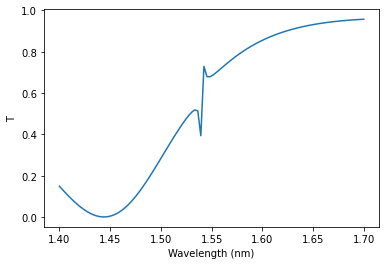

In [19]:
plt.plot(wavelengths, T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('T')
plt.show()